# 리그 오브 레전드 승부 예측 모델

## 1) 데이터 선정 이유 및 문제 정의
### 데이터를 선정 이유

1. E-스포츠에 관심이 있어서.
2. 도메인 지식이 있어서.
3. 시계열 데이터 분류문제에 도전하기 위해서.

### 문제정의

블루팀과 레드팀이 맞붙는 리그오브레전드 경기가 있다.

밴픽까지 진행 한 후, 해당 경기의 결과를 예측할 수 있을까?

* train data = 2014\~2016년 경기 전 데이터와 결과 데이터
* test data = 2017\~2018년 경기 전 데이터
* target - 블루팀의 승리 여부(블루팀의 패배 = 레드팀의 승리)

In [ ]:
# 필요한 외부 라이브러리 설치 및 업데이트
!pip install --upgrade sklearn
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

## 2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

### 가설 선정

1. 총 전적 승률 데이터 보다 최근 전적 승률 데이터가 더 중요하다.

2. 총 전적 승률 데이터 보다 상대 전적 승률 데이터가 더 중요하다.

(상대전적 - 팀 A와 팀 B 간의 역대 전적)

### 베이스라인 모델과 평가 지표

* 베이스라인 모델 - 블루팀 승 또는 레드팀 승만 결과를 보냈을 때 정확도가 높은 값.

* 평가 지표 - 승부 예측 결과를 맞추는 Accuary. 경기 결과 승/패 예측이기 때문에 TP, TN만 확인한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/코드스테이츠/N2xx Section2/Project/LeagueofLegends.csv").dropna(axis=0).reset_index(drop=True)

# def make_target(df):
#     sr_bFirstDragon = df.bDragons.apply(lambda x : float(re.sub("[a-zA-Z_\[\],']"," ",x).split()[0]) if not len(re.sub("[a-zA-Z_\[\],']"," ",x).split())==0 else 120)
#     sr_rFirstDragon = df.rDragons.apply(lambda x : float(re.sub("[a-zA-Z_\[\],']"," ",x).split()[0]) if not len(re.sub("[a-zA-Z_\[\],']"," ",x).split())==0 else 120)
    
#     FristDragonSlainTeam = (sr_bFirstDragon < sr_rFirstDragon).astype(int) # 1이면 블루팀이 첫 용, 0이면 레드팀이 첫 용
#     FirstDragonSlainTime = FristDragonSlainTeam * sr_bFirstDragon + (1-FristDragonSlainTeam) * sr_rFirstDragon
#     return FristDragonSlainTeam, FirstDragonSlainTime

# target, target_time = make_target(df)

base_line = (df["bResult"].value_counts()/len(df)*100).sort_values(ascending=False)
base_line_accuray = max(base_line)/100
print("베이스라인 모델 정확도 :",base_line_accuray)

베이스라인 모델 정확도 : 0.54431548404115


## 3) EDA와 데이터 전처리

### EDA


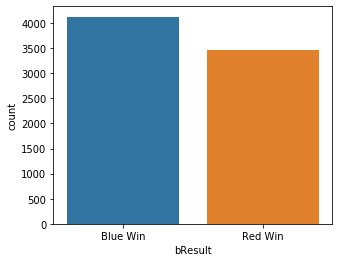

In [37]:
plt.figure(figsize = (5,4))
sns.countplot(data = df["bResult"], x = df["bResult"])
plt.xticks([0, 1], labels = ["Blue Win","Red Win"])
plt.show()

타겟 밸런스는 5.5:4.5 정도로 나쁘지 않은 편이다.

### Feature Engineering
1. 불필요한 피쳐, 인덱스 제거
2. 시계열로 데이터 정렬
3. 각 팀별 총 전적 피쳐 추가
4. 두 팀을 뽑아 상대 전적 피쳐 추가
5. 각 팀이 속한 리그 추가(국제 경기에서 사용됨)

In [5]:
def feature_en(df):
    ## 불필요한 피쳐 드랍
    drop_features = ["golddiff", "goldblue", "bKills", "bTowers", "bInhibs", "bDragons", "bBarons", "bHeralds", "goldred", "rKills", "rTowers", "rInhibs", "rDragons", "rBarons", "rHeralds", "gamelength",
                 "goldblueTop", "goldblueJungle", "goldblueMiddle", "goldblueADC", "goldblueSupport", "goldredTop", "goldredJungle", "goldredMiddle", "goldredADC", "goldredSupport", "Address"]
    temp = df.drop(drop_features, axis=1)

    ## 데이터 부족한 인덱스 드랍
    y = temp.groupby("blueTeamTag").sum()[["bResult","rResult"]]
    y.columns = ["Win","Lose"]
    x = temp.groupby("redTeamTag").sum()[["rResult","bResult"]]
    x.columns = ["Win","Lose"]
    wl = x+y
    drop_team = wl[wl.isna()["Win"]].index
    temp = temp.drop(temp[(temp.blueTeamTag.apply(lambda x: True if x in drop_team else False))].index)
    temp = temp.drop(temp[(temp.redTeamTag.apply(lambda x: True if x in drop_team else False))].index)

    ## sort를 위한 label 인코딩후 원복.
    # Season = ["Spring", "Summer"] -> [1,2]
    # Type = ['Promotion', 'Season', 'Playoffs', 'Regional', 'International'] -> [1,2,3,4,5]
    temp.Season = temp.Season.apply(lambda x : 2 if x == "Summer" else 1)
    temp.  Type = temp.  Type.apply(lambda x : 5 if x == "International" 
                                          else 4 if x == "Regional" 
                                          else 3 if x == "Playoffs" 
                                          else 2 if x == "Season" else 1)
    temp = temp.sort_values(["Year","Season","Type"]).reset_index(drop=True)
    temp.Season = temp.Season.apply(lambda x : "Summer"        if x == 2 else "Spring")
    temp.  Type = temp.  Type.apply(lambda x : "International" if x == 5 
                                          else "Regional"      if x == 4
                                          else "Playoffs"      if x == 3
                                          else "Season"        if x == 2 else "Promotion")

    ## 블루벤, 레드벤 리스트를 피쳐로 바꾸고 드랍
    temp[["bBan1","bBan2","bBan3","bBan4","bBan5"]] = pd.DataFrame(temp.blueBans.str.replace("[","")\
                                                                                .str.replace("]","")\
                                                                                .str.replace("'","")\
                                                                                .str.replace(" ","")\
                                                                                .str.split(",")
                                                                                .tolist(),columns=["bBan1","bBan2","bBan3","bBan4","bBan5"])
    temp[["rBan1","rBan2","rBan3","rBan4","rBan5"]] = pd.DataFrame(temp. redBans.str.replace("[","")\
                                                                                .str.replace("]","")\
                                                                                .str.replace("'","")\
                                                                                .str.replace(" ","")\
                                                                                .str.split(",")
                                                                                .tolist(),columns=["rBan1","rBan2","rBan3","rBan4","rBan5"])
    temp = temp.drop(["blueBans","redBans"],axis=1)

    # 총 전적, 승률, 최근 10 경기 전적, 승률
    temp.redTeamTag = temp.redTeamTag.str.upper()
    temp.blueTeamTag = temp.blueTeamTag.str.upper()
    teamList = temp.blueTeamTag.unique()
    temp.loc[:,["bW","bL","bWR","rW","rL","rWR","bWr10","bLr10","bWRr10","rWr10","rLr10","rWRr10"]] = 0
    for i in teamList:
        x = temp[["blueTeamTag", "bResult", "rResult", "redTeamTag", "bW","bL","bWR","rW","rL","rWR","bWr10","bLr10","bWRr10","rWr10","rLr10","rWRr10"]]\
                    [((temp.blueTeamTag == i) | (temp.redTeamTag == i))]
        for j in range(1,len(x)):
            # 총 전적
            if x.blueTeamTag.iloc[j] == i:
                x.bW.iloc[j] = x.bW.iloc[j-1] + x.bResult.iloc[j-1] if (x.blueTeamTag.iloc[j-1] == x.blueTeamTag.iloc[j]) else x.rW.iloc[j-1] + x.rResult.iloc[j-1]
                x.bL.iloc[j] = x.bL.iloc[j-1] + x.rResult.iloc[j-1] if (x.blueTeamTag.iloc[j-1] == x.blueTeamTag.iloc[j]) else x.rL.iloc[j-1] + x.bResult.iloc[j-1]
            else:
                x.rW.iloc[j] = x.rW.iloc[j-1] + x.rResult.iloc[j-1] if (x.redTeamTag.iloc[j-1] == x.redTeamTag.iloc[j]) else x.bW.iloc[j-1] + x.bResult.iloc[j-1]
                x.rL.iloc[j] = x.rL.iloc[j-1] + x.bResult.iloc[j-1] if (x.redTeamTag.iloc[j-1] == x.redTeamTag.iloc[j]) else x.bL.iloc[j-1] + x.rResult.iloc[j-1]
            # 최근 10경기 전적
            if j > 10 :
                if x.blueTeamTag.iloc[j] == i:
                    x.bWr10.iloc[j] = x.bW.iloc[j] - x.bW.iloc[j-10] if (x.blueTeamTag.iloc[j-10] == x.blueTeamTag.iloc[j]) else x.bW.iloc[j] - x.rW.iloc[j-10]
                    x.bLr10.iloc[j] = x.bL.iloc[j] - x.bL.iloc[j-10] if (x.blueTeamTag.iloc[j-10] == x.blueTeamTag.iloc[j]) else x.bL.iloc[j] - x.rL.iloc[j-10]
                else:
                    x.rWr10.iloc[j] = x.rW.iloc[j] - x.rW.iloc[j-10] if (x.redTeamTag.iloc[j-10] == x.redTeamTag.iloc[j]) else x.rW.iloc[j] - x.bW.iloc[j-10]
                    x.rLr10.iloc[j] = x.rL.iloc[j] - x.rL.iloc[j-10] if (x.redTeamTag.iloc[j-10] == x.redTeamTag.iloc[j]) else x.rL.iloc[j] - x.bL.iloc[j-10]
            else:
                if x.blueTeamTag.iloc[j] == i:
                    x.bWr10.iloc[j] = x.bW.iloc[j]
                    x.bLr10.iloc[j] = x.bL.iloc[j]
                else:
                    x.rWr10.iloc[j] = x.rW.iloc[j]
                    x.rLr10.iloc[j] = x.rL.iloc[j]
        x.bWR = x.bW/(x.bW+x.bL); x.rWR = x.rW/(x.rW+x.rL); x.bWRr10 = x.bWr10/(x.bWr10+x.bLr10); x.rWRr10 = x.rWr10/(x.rWr10+x.rLr10)
        temp.loc[x.index,["bW","bL","bWR","rW","rL","rWR","bWr10","bLr10","bWRr10","rWr10","rLr10","rWRr10"]] = x.loc[:,["bW","bL","bWR","rW","rL","rWR","bWr10","bLr10","bWRr10","rWr10","rLr10","rWRr10"]]
        
    # 상대 전적, 최근 5 경기 상대 전적
    from itertools import combinations
    temp.loc[:,["bRW","rRW","bRWR","rRWR","bRWr5","rRWr5","bRWRr5","rRWRr5"]] = 0
    for i in combinations(teamList, 2):
        x = temp[["blueTeamTag", "bResult", "rResult", "redTeamTag", "bRW","rRW","bRWR","rRWR","bRWr5","rRWr5","bRWRr5","rRWRr5"]]\
            [(((temp.blueTeamTag == i[0]) & (temp.redTeamTag == i[1])) | ((temp.blueTeamTag == i[1]) & (temp.redTeamTag == i[0])))]
        for j in range(1,len(x)): 
            # 상대 전적
            x.bRW.iloc[j] = x.bRW.iloc[j-1]+x.bResult.iloc[j-1] if (x.blueTeamTag.iloc[j-1] == x.blueTeamTag.iloc[j]) else x.rRW.iloc[j-1]+x.rResult.iloc[j-1]
            x.rRW.iloc[j] = x.rRW.iloc[j-1]+x.rResult.iloc[j-1] if (x.blueTeamTag.iloc[j-1] == x.blueTeamTag.iloc[j]) else x.bRW.iloc[j-1]+x.bResult.iloc[j-1]
            # 최근 5경기 상대 전적
            if j > 5 :
                x.bRWr5.iloc[j] = x.bRW.iloc[j]-x.bRW.iloc[j-5] if (x.blueTeamTag.iloc[j-5] == x.blueTeamTag.iloc[j]) else x.bRW.iloc[j]-x.rRW.iloc[j-5]
                x.rRWr5.iloc[j] = x.rRW.iloc[j]-x.rRW.iloc[j-5] if (x.blueTeamTag.iloc[j-5] == x.blueTeamTag.iloc[j]) else x.rRW.iloc[j]-x.bRW.iloc[j-5]
            else :
                x.bRWr5.iloc[j] = x.bRW.iloc[j]
                x.rRWr5.iloc[j] = x.rRW.iloc[j]
        x.bRWR = x.bRW/(x.bRW+x.rRW); x.rRWR = x.rRW/(x.bRW+x.rRW); x.bRWRr5 = x.bRWr5/(x.bRWr5+x.rRWr5); x.rRWRr5 = x.rRWr5/(x.bRWr5+x.rRWr5)
        temp.loc[x.index,["bRW","rRW","bRWR","rRWR","bRWr5","rRWr5","bRWRr5","rRWRr5"]] = x.loc[:,["bRW","rRW","bRWR","rRWR","bRWr5","rRWr5","bRWRr5","rRWRr5"]]
    temp = temp.fillna(0.5)
    return temp
df_fe = feature_en(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### 아쉬운 특성공학의 결과물

In [6]:
champs= list(set(df["blueTopChamp"].unique())
            |set(df["blueJungleChamp"].unique())
            |set(df["blueMiddleChamp"].unique())
            |set(df["blueADCChamp"].unique())
            |set(df["blueSupportChamp"].unique())
            |set(df["redTopChamp"].unique())
            |set(df["redJungleChamp"].unique())
            |set(df["redMiddleChamp"].unique())
            |set(df["redADCChamp"].unique())
            |set(df["redSupportChamp"].unique()))
            # |set(df["bBan1"].unique())
            # |set(df["bBan2"].unique())
            # |set(df["bBan3"].unique())
            # |set(df["bBan4"].unique())
            # |set(df["bBan5"].unique())
            # |set(df["rBan1"].unique())
            # |set(df["rBan2"].unique())
            # |set(df["rBan3"].unique())
            # |set(df["rBan4"].unique())
            # |set(df["rBan5"].unique()))
champs.sort()
len(champs)

140

In [7]:
# def fe_champ(df):
#     df_champ = pd.DataFrame(data = champ_dict,index=["CType","AD","AP","ETC","Init"]).T
#     CType = list(df_champ.CType.unique())
#     df_mc = df[["blueTopChamp","blueJungleChamp","blueMiddleChamp","blueADCChamp","blueSupportChamp","redTopChamp","redJungleChamp","redMiddleChamp","redADCChamp","redSupportChamp"]]

#     temp1 = pd.DataFrame([[0]*(len(CType)+3)]*len(df_mc),columns=CType+["bAD","bAP","bInit"])
#     temp2 = pd.DataFrame([[0]*(len(CType)+3)]*len(df_mc),columns=CType+["rAD","rAP","rInit"])
#     for i in range(len(df_mc)):
#         temp1.loc[i, df_champ.loc[df_mc.blueTopChamp[i]    ,"CType"]] += 1
#         temp1.loc[i, df_champ.loc[df_mc.blueJungleChamp[i] ,"CType"]] += 1
#         temp1.loc[i, df_champ.loc[df_mc.blueMiddleChamp[i] ,"CType"]] += 1
#         temp1.loc[i, df_champ.loc[df_mc.blueADCChamp[i]    ,"CType"]] += 1
#         temp1.loc[i, df_champ.loc[df_mc.blueSupportChamp[i],"CType"]] += 1
#         temp1.loc[i,["bAD","bAP","bInit"]]  = np.array(df_champ.loc[df_mc.blueTopChamp[i],    ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc.blueJungleChamp[i], ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc.blueMiddleChamp[i], ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc.blueADCChamp[i],    ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc.blueSupportChamp[i],["AD","AP","Init"]])

#         temp2.loc[i, df_champ.loc[df_mc. redTopChamp[i],    "CType"]] += 1
#         temp2.loc[i, df_champ.loc[df_mc. redJungleChamp[i], "CType"]] += 1
#         temp2.loc[i, df_champ.loc[df_mc. redMiddleChamp[i], "CType"]] += 1
#         temp2.loc[i, df_champ.loc[df_mc. redADCChamp[i],    "CType"]] += 1
#         temp2.loc[i, df_champ.loc[df_mc. redSupportChamp[i],"CType"]] += 1
#         temp2.loc[i,["rAD","rAP","rInit"]]  = np.array(df_champ.loc[df_mc. redTopChamp[i],    ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc. redJungleChamp[i], ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc. redMiddleChamp[i], ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc. redADCChamp[i],    ["AD","AP","Init"]])\
#                                             + np.array(df_champ.loc[df_mc. redSupportChamp[i],["AD","AP","Init"]])

#     temp = pd.concat([temp1,temp2],axis=1)
#     temp.columns = ["bBruser", "bAssasin", "bTank", "bMage", "bNuker", "bADcarry", "bSupport","bAD","bAP","bInit","rBruser", "rAssasin", "rTank", "rMage", "rNuker", "rADcarry", "rSupport","rAD","rAP","rInit"]
#     temp = pd.concat([df,temp],axis=1)
#     # temp[["blueTopChamp","blueJungleChamp","blueMiddleChamp","blueADCChamp","blueSupportChamp","redTopChamp","redJungleChamp","redMiddleChamp","redADCChamp","redSupportChamp"]]=\
#     # temp[["blueTopChamp","blueJungleChamp","blueMiddleChamp","blueADCChamp","blueSupportChamp","redTopChamp","redJungleChamp","redMiddleChamp","redADCChamp","redSupportChamp"]].applymap(lambda x: df_champ.CType[x])
#     return temp
# df_fe = fe_champ(df_fe1)
# # df_fe = df_fe1

#### 팀에 리그 태그 특성 추가

In [8]:
league_team = {}
for i in set(df_fe.League.unique())- set(("IEM","MSI","WC","RR","LCL")):
    league_team[i]=list(set(df_fe[df_fe.League==i].blueTeamTag.unique())|set(df_fe[df_fe.League==i].redTeamTag.unique()))
league_team["LCK"].append("SSW")
league_team["LCK"].append("SSB")
league_team["LCK"].append("NWS")
df_fe[["bTeamLeagueTag","rTeamLeagueTag"]] = "ETC"
for k, v in league_team.items():
    for i in range(len(df_fe)):
        if df_fe.Type[i] =="International":
            if df_fe.blueTeamTag[i] in v: df_fe.loc[i,"bTeamLeagueTag"] = k
            if df_fe. redTeamTag[i] in v: df_fe.loc[i,"rTeamLeagueTag"] = k
        else :
            df_fe.loc[i,"bTeamLeagueTag"] = df_fe.League[i]
            df_fe.loc[i,"rTeamLeagueTag"] = df_fe.League[i]
            # df_fe.League[i] = "Local"

### **Data Leakage**
밴픽 결과를 보고 승부를 예측한다는 가정이 있기 때문에

대회를 진행하는 날 승부예측을 진행한다.

따라서 데이터 Leakage는 없다.

### **모델의 유용성**
* 이 모델은 밴픽이 끝난 후 승부를 예측하는 데 유용하다.

### **모델의 한계**
* 경기 전날 예측하는 데에는 사용할 수 없다.
* 패치버전 별로 선수의 능력치와 사용하는 챔피언 능력치가 달라지는데, 이를 반영할 수 있는 데이터가 없다.
* 위와 같은 이유로, 예측 데이터를 train data로 추가하면 할 수록 train data의 의미가 사라진다.

 -> 즉, 1회성이고 반복해서 사용하려면 패치 정보를 반영해야한다.

## 4) 머신러닝 방식 적용 및 교차검증

4가지 분류모델을 사용해서 voting ensemble 모델을 통해 결과를 확인

1. Logistic Regression
2. Random Forest
3. Ada Boost
4. XGBoost

In [9]:
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### train, test set 분리, encoding

In [ ]:
# X = df_fe.drop(["bResult","rResult"],axis=1)
# y = df_fe["bResult"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=42)

train = df_fe[df_fe.Year<=2016]
test = df_fe[df_fe.Year>2016]
X_train = train.drop(["bResult","rResult"],axis=1)
y_train = train["bResult"]
X_test = test.drop(["bResult","rResult"],axis=1)
y_test = test["bResult"]

pipe_pre = make_pipeline(
    OneHotEncoder(cols=["League", "Year", "Season", "Type"], use_cat_names=True),
    TargetEncoder(smoothing=5,min_samples_leaf=100),
    SimpleImputer())

X_train_pre = pipe_pre.fit_transform(X_train,y_train)
X_test_pre = pipe_pre.transform(X_test)

feature_names = list(pipe_pre.named_steps["onehotencoder"].feature_names)
X_train_pre_df = pd.DataFrame(X_train_pre,columns=feature_names)
X_test_pre_df = pd.DataFrame(X_test_pre,columns=feature_names)

In [11]:
base_score = (y_test.value_counts()/len(y_test))[1]
base_score

0.5529875986471251

### 1. Logistic Regression

In [10]:
pipelr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=0.0004, fit_intercept=True, 
                       intercept_scaling=1, class_weight=None, random_state=42, solver='lbfgs', 
                       max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None)
)

pipelr.fit(X_train_pre_df, y_train)
pipe_pre.named_steps["onehotencoder"].feature_names
print("정확도 :",(pipelr.predict(X_test_pre_df) == y_test).sum()/len(X_test_pre_df))

정확도 : 0.6324689966178129


### 2. Random Forest

In [12]:
rfc = RandomForestClassifier(n_estimators = 200, min_samples_leaf=120,random_state=42)
rfc.fit(X_train_pre_df, y_train)
print("정확도 :",(rfc.predict(X_test_pre_df) == y_test).sum()/len(X_test_pre_df))

정확도 : 0.6310597519729425


#### Randomized Search CV at Random Forest

In [13]:
# from scipy.stats import randint
# dists = {
#     "targetencoder__smoothing": [1.,2.,3.,4.,5.,7.5,10.,15.,20.],
#     "targetencoder__min_samples_leaf": randint(1, 300),
#     "randomforestclassifier__n_estimators": randint(50, 350),
#     "randomforestclassifier__min_samples_leaf": randint(20, 200)
# }
# clf = RandomizedSearchCV(piperf, dists, 
#                          n_iter=50, 
#                          cv=3, 
#                          scoring="accuracy", 
#                          n_jobs=-1, 
#                          verbose=1, 
#                          pre_dispatch='2*n_jobs')

# clf.fit(X_train,y_train)
# clf.best_score_

In [14]:
# clf.best_params_

In [15]:
# (clf.best_estimator_.predict(X_test)==y_test).sum()/len(X_test)

### 3. Ada Boost

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=0.05, algorithm='SAMME.R', random_state=42)
ada.fit(X_train_pre_df,y_train)

(ada.predict(X_test_pre_df)==y_test).sum()/len(X_test_pre_df)

0.6319052987598647

### 4. XGBoost

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=1000, verbosity=0, silent=None, objective='binary:logistic', booster='dart', #gblinear gbtree dart
                    tree_method="approx", n_jobs=-1, nthread=None, gamma=1, min_child_weight=1, max_delta_step=1, subsample=1, colsample_bytree=0.5, colsample_bylevel=0.5, 
                    colsample_bynode=0.8, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=base_score, random_state=0, seed=None, missing=None)

xgb.fit(X_train_pre_df,y_train,
        eval_set=[(X_train_pre_df,y_train),
                  (X_test_pre_df,y_test)],
        early_stopping_rounds=50)
(xgb.predict(X_test_pre_df)==y_test).sum()/len(X_test_pre_df)

[0]	validation_0-error:0.463664	validation_1-error:0.447012
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.463664	validation_1-error:0.447012
[2]	validation_0-error:0.463664	validation_1-error:0.447012
[3]	validation_0-error:0.463664	validation_1-error:0.447012
[4]	validation_0-error:0.463664	validation_1-error:0.447012
[5]	validation_0-error:0.463664	validation_1-error:0.447012
[6]	validation_0-error:0.463664	validation_1-error:0.447012
[7]	validation_0-error:0.463664	validation_1-error:0.447012
[8]	validation_0-error:0.463664	validation_1-error:0.447012
[9]	validation_0-error:0.463664	validation_1-error:0.447012
[10]	validation_0-error:0.463664	validation_1-error:0.447012
[11]	validation_0-error:0.463664	validation_1-error:0.447012
[12]	validation_0-error:0.463664	validation_1-error:0.447012
[13]	validation_0-error:0.463664	validation_1-error:0.44

0.6324689966178129

### 5. Voting Ensemble

In [19]:
from sklearn.ensemble import VotingClassifier

estimators = [("rfc",rfc),("xgb",xgb),("ada",ada),("pipelr",pipelr)]

voc = VotingClassifier(estimators, voting='hard', weights=None, n_jobs=-1, flatten_transform=True)
voc2 = VotingClassifier(estimators, voting='soft', weights=None, n_jobs=-1, flatten_transform=True)
voc.fit(X_train_pre_df, y_train)
voc2.fit(X_train_pre_df, y_train)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=120,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
     

In [20]:
print('Soft Voting 분류기 정확도', (voc2.predict(X_test_pre_df)==y_test).sum()/len(y_test))
print('Hard Voting 분류기 정확도', (voc.predict(X_test_pre_df)==y_test).sum()/len(y_test))


Soft Voting 분류기 정확도 0.6302142051860203
Hard Voting 분류기 정확도 0.6330326944757609


각 머신러닝 모델에서 predict와 predict probability로 체크

In [21]:
n_ens = 4
y_pred_soft = (rfc.   predict_proba(X_test_pre_df)\
             + xgb.   predict_proba(X_test_pre_df)\
             + ada.   predict_proba(X_test_pre_df)\
             + pipelr.predict_proba(X_test_pre_df)\
             )/n_ens>0.5
y_pred_hard = (rfc.   predict(X_test_pre_df)\
             + xgb.   predict(X_test_pre_df)\
             + ada.   predict(X_test_pre_df)\
             + pipelr.predict(X_test_pre_df)\
             )/n_ens>0.5
print('Soft Voting 분류기 정확도', (y_test==y_pred_soft.T[1]).sum()/len(y_test))
print('Hard Voting 분류기 정확도', (y_test==y_pred_hard).sum()/len(y_test))

Soft Voting 분류기 정확도 0.629086809470124
Hard Voting 분류기 정확도 0.6316234498308907


최종 모델의 test 점수는 0.633 이다.

Q1) 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?

*   더 잘 나왔다.
*   weight가 밸런스한 데이터의 베이스라인을 사용했기 때문에 베이스 라인 성능이 매우 낮음
*   특성공학을 해서 결과에 유의미한 영향을 주는 특성을 추가 했기 때문


Q2) 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?

* randomized search cv를 통해 하이퍼파라미터를 구함
* 하이퍼파라미터를 직접 수정하면서 결과를 도출
* 이유 : grid search보다 빠르게 결과를 받아볼 수 있었기 때문

Q3) 최종 모델에 관해 설명하세요.

최종 모델은 위에 사용한 로지스틱회귀, 랜덤 포레스트, Ada 부스트, XG부스트를 사용해 만든 voting 분류기이다.

hard voting이 성능이 더 높게 나와서 hard voting 분류기를 채택했다.

## 5) 머신러닝 모델 해석


### 1. Permutation Importance

In [22]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    voc2,
    scoring='accuracy', # metric
    n_iter=10
)


permuter.fit(X_test_pre_df, y_test)

pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0027 ± 0.0026,blueJungle
0.0020 ± 0.0038,bWRr10
0.0012 ± 0.0020,blueSupport
0.0012 ± 0.0027,bL
0.0005 ± 0.0021,rWr10
0.0005 ± 0.0029,blueJungleChamp
0.0005 ± 0.0032,redSupport
0.0004 ± 0.0006,League_LMS
0.0003 ± 0.0010,Type_International
0.0003 ± 0.0005,League_LCK


초록색 부분은 블루팀 승률을 높이는 특성들이고

붉은색 부분은 레드팀 승률을 높이는 특성들이다.

* 블루팀 승률을 높이는 특성들
    1. 블루팀 정글러
    2. 블루팀 최근 10판 승률
    3. 블루팀 서포터
    4. 블루팀 패배 수
    5. 레드팀 최근 10판 승리 수

* 블루팀 승률을 낮추는 특성들
    1. 블루팀 세번째 밴 챔피언
    2. 레드팀 최근 10판 승률
    3. 블루팀 상대전적 최근 5판 승률
    4. 레드팀 상대전적 최근 5판 승률
    5. 블루팀 미드 챔피언

* 의미 없는 특성들
    1. 양팀 네번째, 다섯번째 밴 챔피언
    2. 리그 이름(지역)
    3. 경기가 있었던 연도
    4. 시즌

2. PDP plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


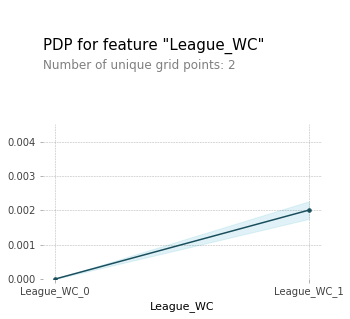

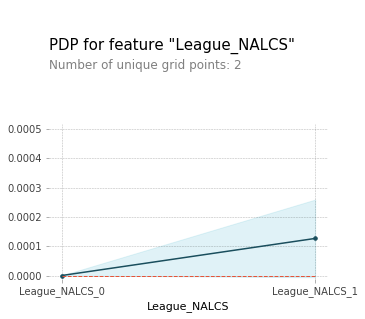

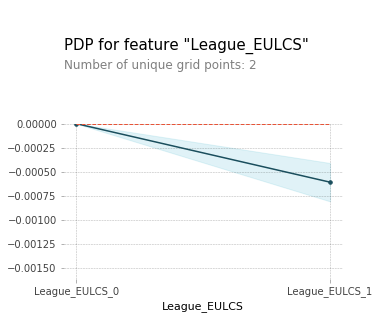

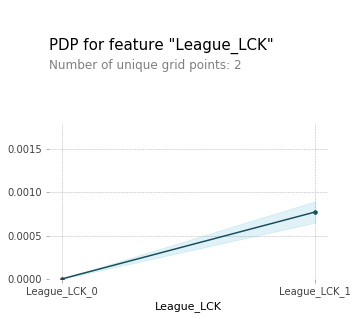

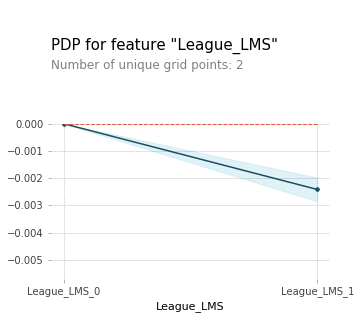

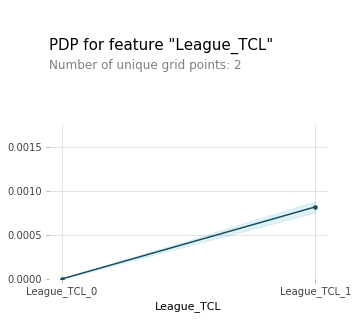

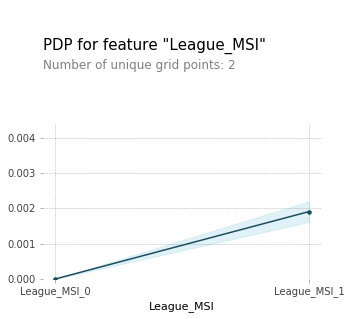

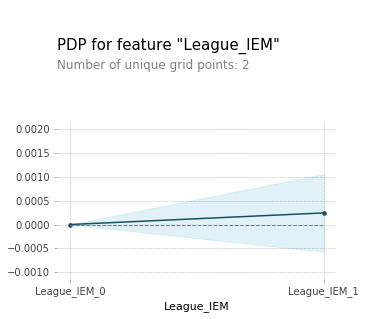

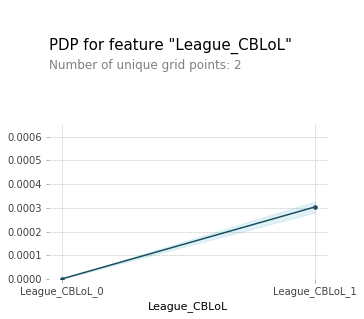

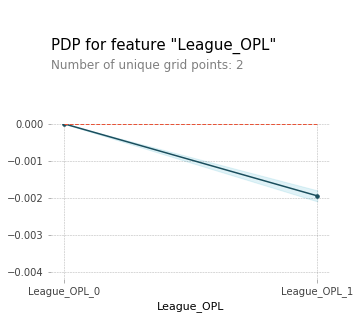

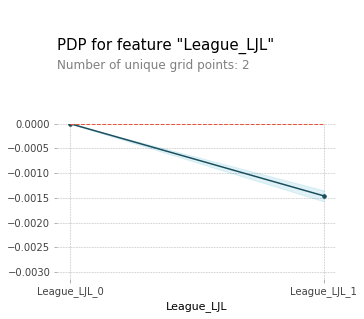

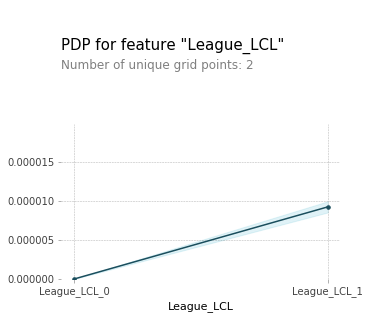

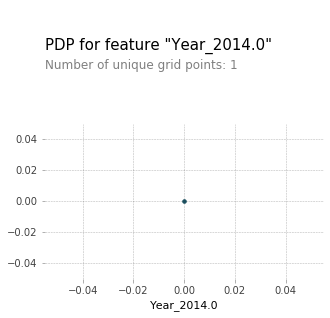

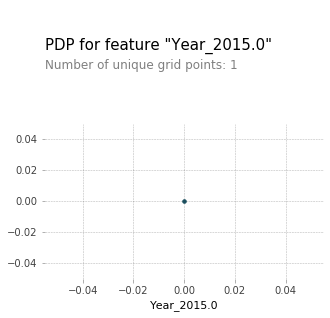

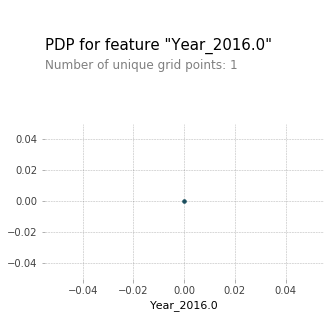

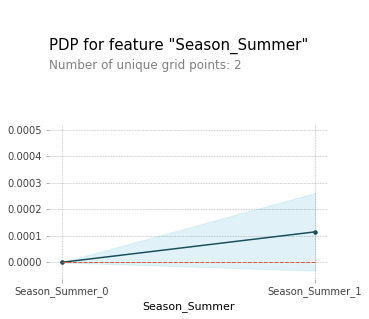

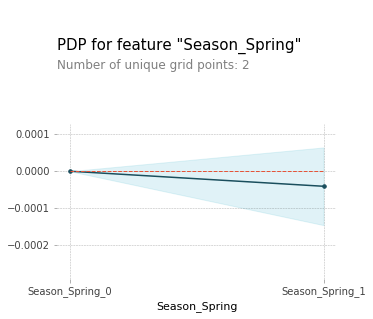

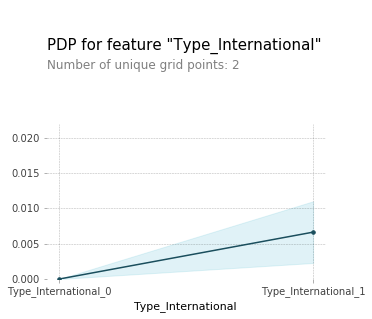

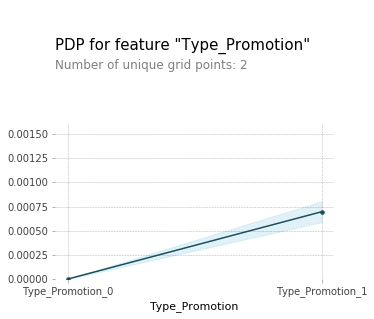

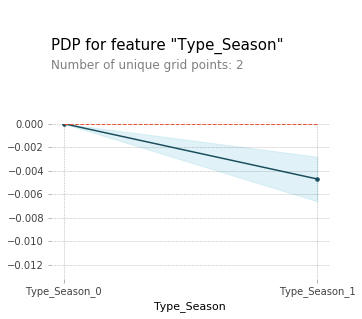

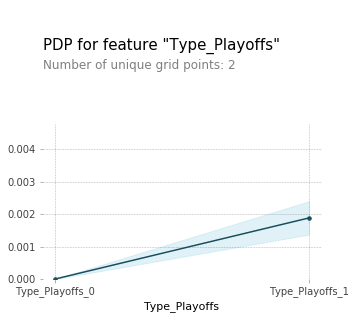

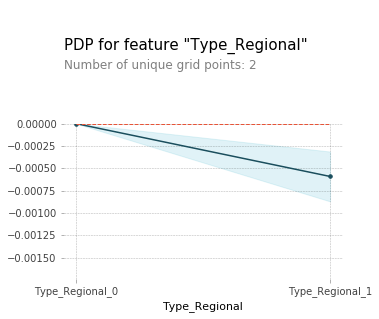

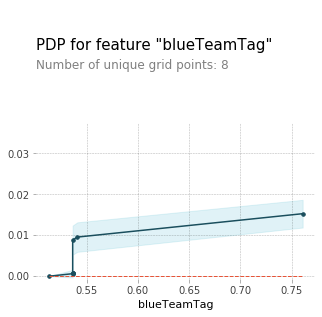

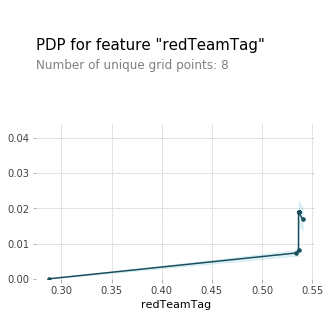

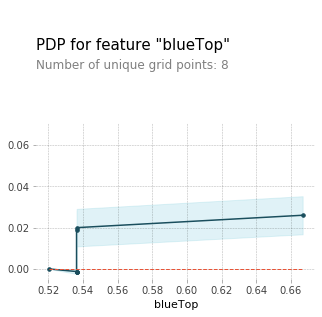

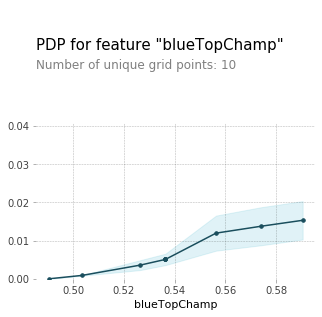

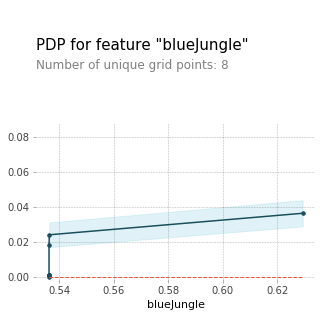

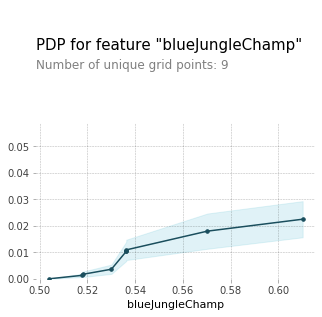

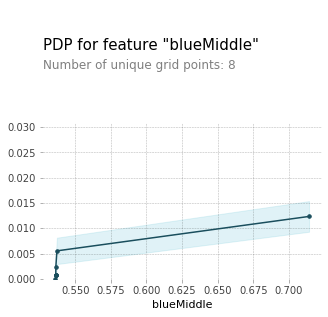

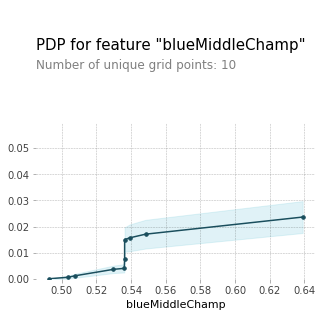

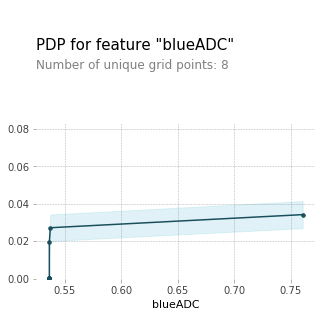

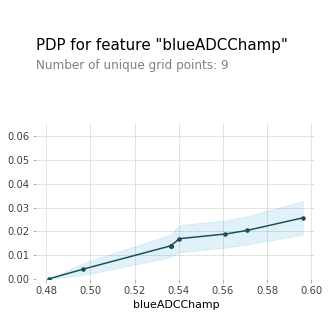

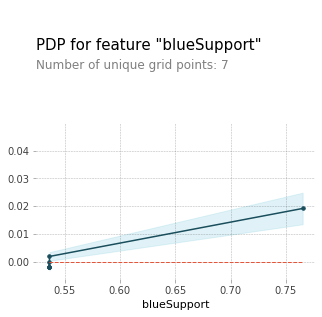

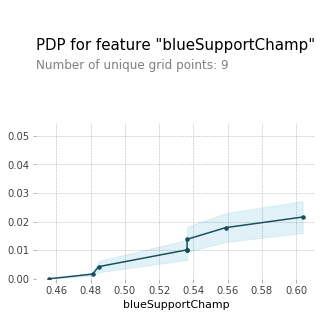

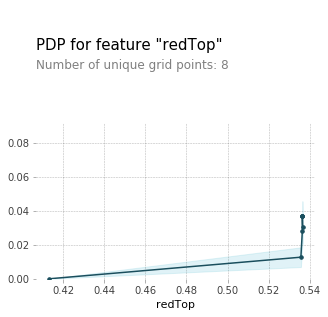

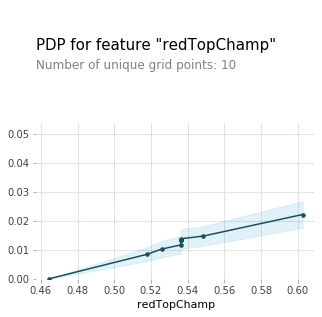

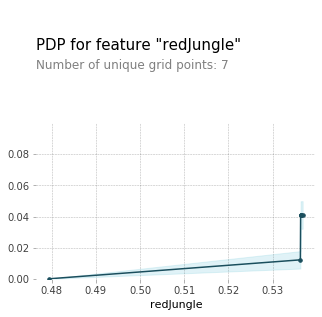

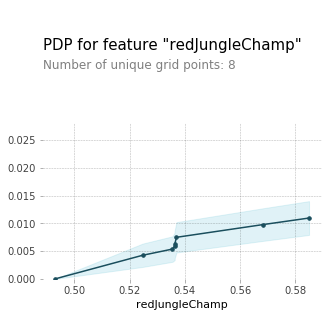

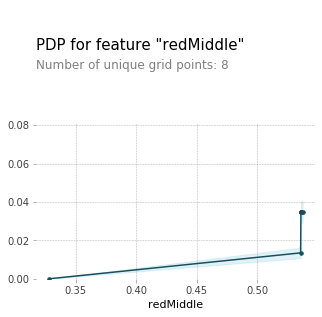

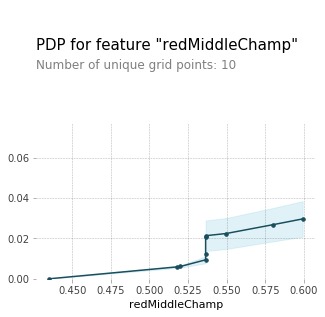

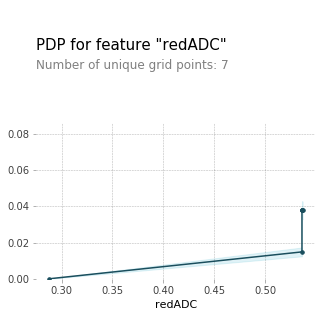

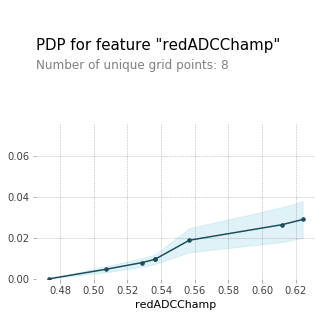

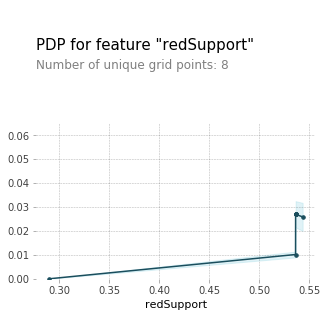

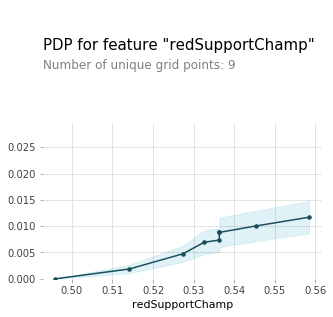

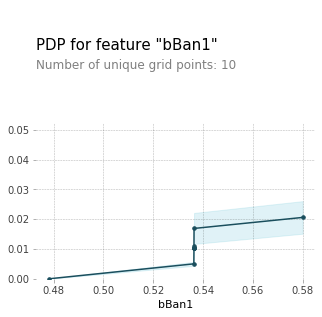

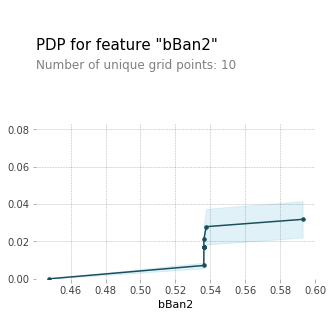

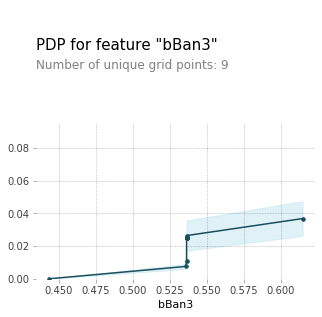

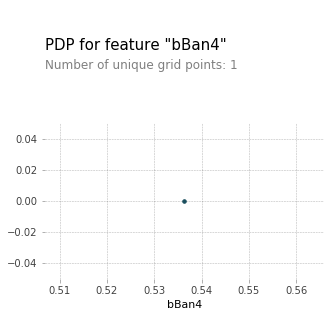

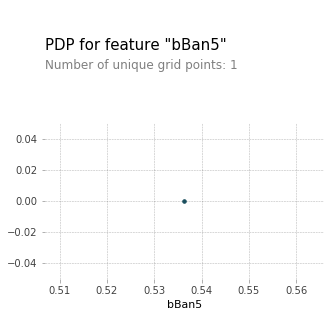

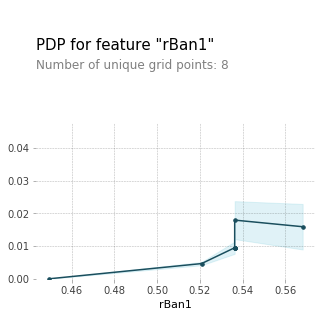

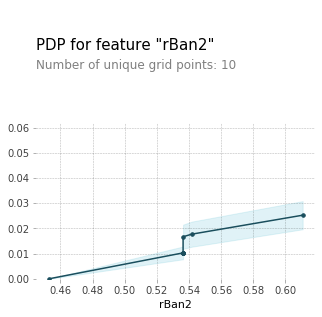

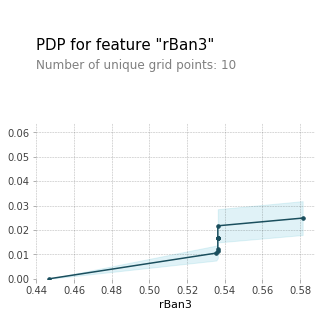

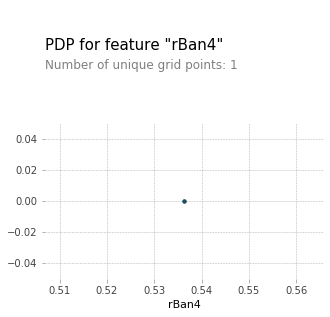

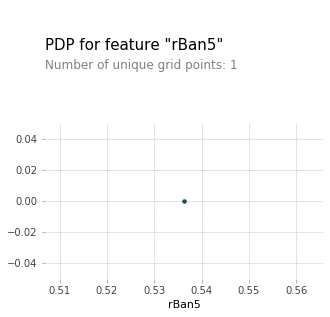

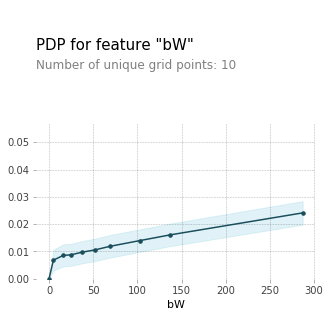

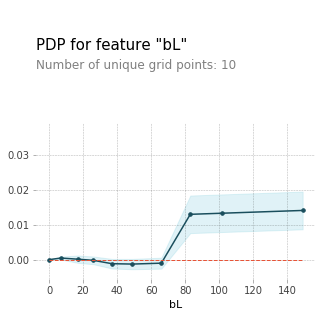

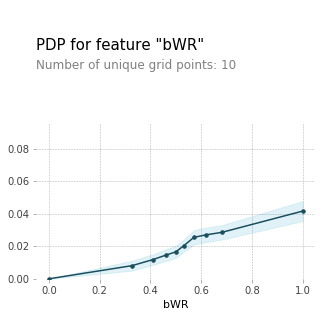

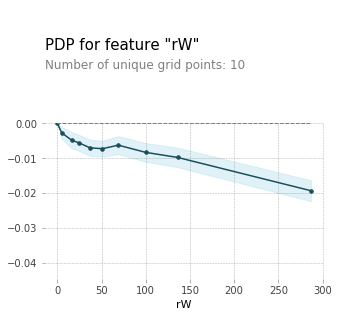

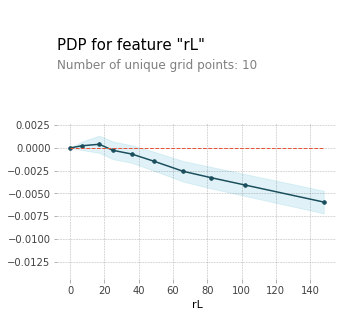

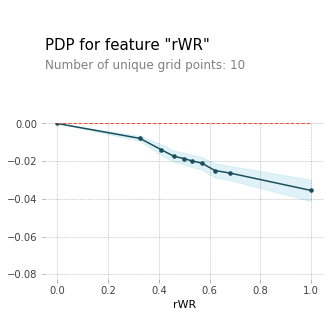

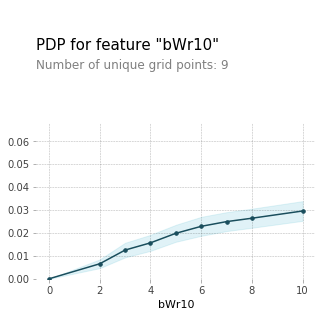

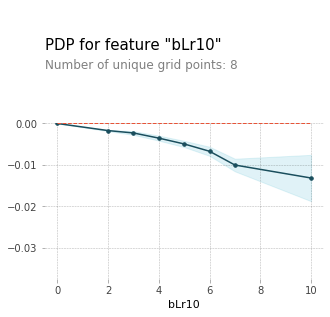

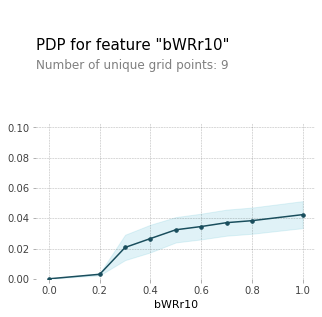

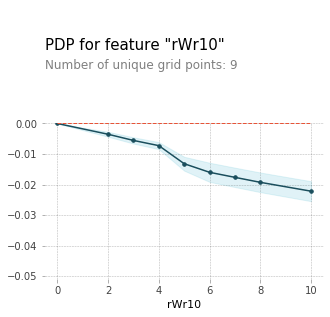

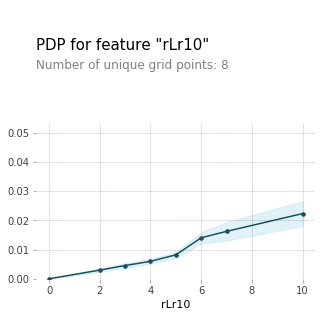

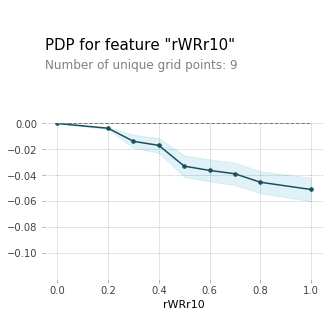

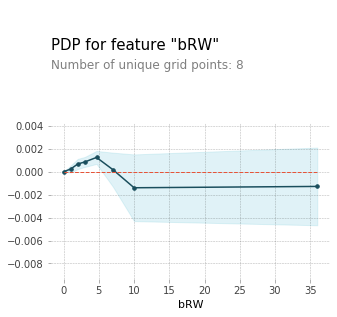

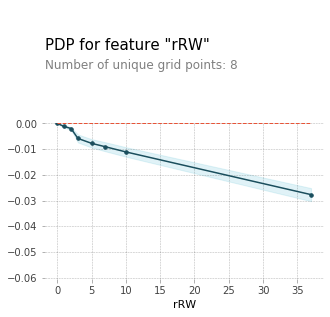

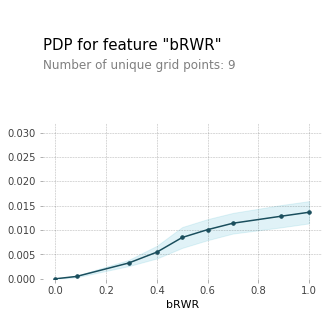

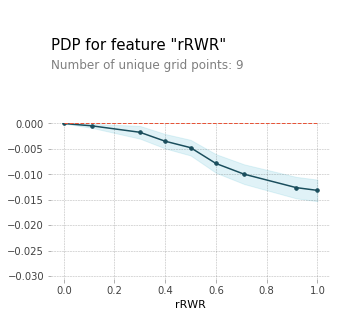

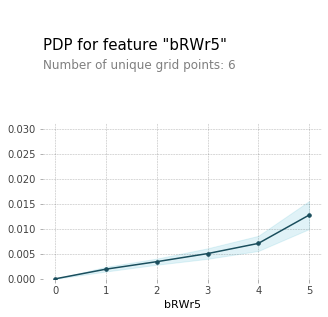

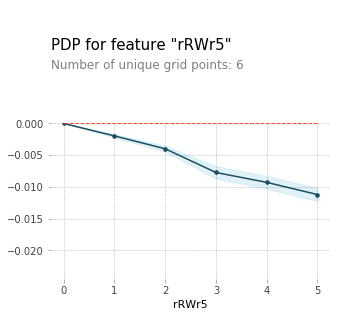

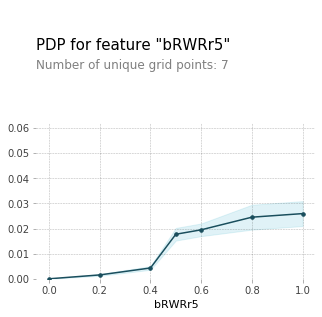

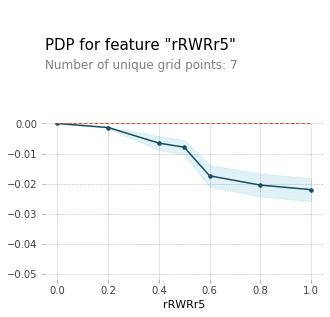

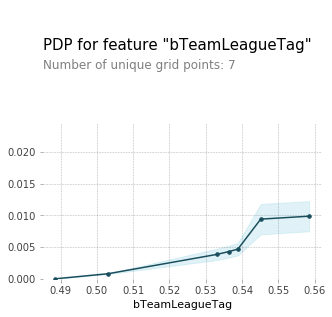

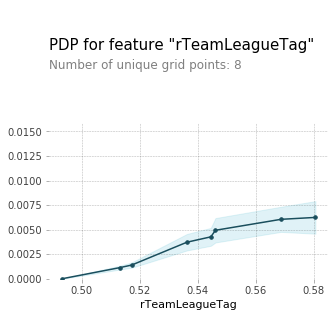

In [23]:
from pdpbox.pdp import pdp_isolate, pdp_plot

for i in feature_names :
    isolated = pdp_isolate(
        model=voc2,
        dataset=X_test_pre_df, 
        model_features=feature_names, 
        feature=i,
        grid_type='percentile', 
        num_grid_points=10
    )
    pdp_plot(isolated, i, figsize=(5,5))

**1. 의미 없는 특성들**

PDP plot을 보면 의미 없는 특성들이 많이 보인다.

우선 Year 정보는 원핫인코딩을 해버려서 의미가 없어졌다.

2017년 2018년에는 2014~2016년 값이 없기 때문에 머신러닝에 전혀 도움이 되지 않았다. 제거해도 되는 특성.

마찬가지로 ban4와 ban5 또한 2016년까지는 없던 기능이라 예측에 어떤 영향도 주지 않았다. 제거해도 되는 특성.

시즌이나 리그 이름 역시 0.01% 영향을 주는 등 사실상 영향이 거의 없다.

하지만 리그 타입은 어느정도 영향이 있는 것으로 보인다.

선수들이 playoff나 국제전에서는 season 보다 긴장을 하거나, 집중을 더 하는 등 변화가 있는 것으로 보인다.

**2. 특성공학을 통해 추가한 특성들**

국제전에서 리그 태그에 따라 1% 정도 변화가 있다. 즉, 자주 이기는 리그 출신이 있다는 것으로 해석할 수 있다.

전체 전적, 최근 전적 승률이  높을수록 최대 승률이 4% 정도 승률 변화에 영향을 준다. 

또한 전체 상대전적, 최근 상대전적 높을수록 최대 승률이 2% 정도 승률 변화에 영향을 준다. 

하지만 승리 수나 패배 수는 직접적인 영향을 주지는 않는다. 아무래도 승리 수와 패배 수보다는 승률이 더 지배적인 특성인 것으로 보인다.

### 3. SHAP
#### Force plot of Shap value

In [24]:
import shap

ohe = OneHotEncoder(cols=["League", "Year", "Season", "Type"], use_cat_names=True)
ohe.fit(X_train,y_train)
X_test_masker = ohe.transform(X_test).reset_index(drop=True)
explainer = shap.Explainer(voc2.predict_proba,X_test_pre_df,algorithm="auto")
n = 0 # n 행

### Draw SHAP plots ###
shap_values_1 = explainer.shap_values(X_test_pre_df.iloc[[n]])

shap.initjs()
shap.force_plot(shap_values_1[...,1][0])

Shap의 force_plot을 보면 확률에 영향을 크게 주는 특성을 확인할 수 있다.

데이터 하나를 뽑아 확인해 보면 위와 같이 나온다.

타겟 인코딩을 해서 categorical data들이 숫자로 나오는데, 실제 값은 taget encoder의 매핑 값을 통해 알 수 있다.

#### Shap value summary plot

Summary plot으로 모든 특성들에 대해 간략하게 알아볼 수 있다.

In [ ]:
# shap_values = explainer.shap_values(X_test_pre_df)

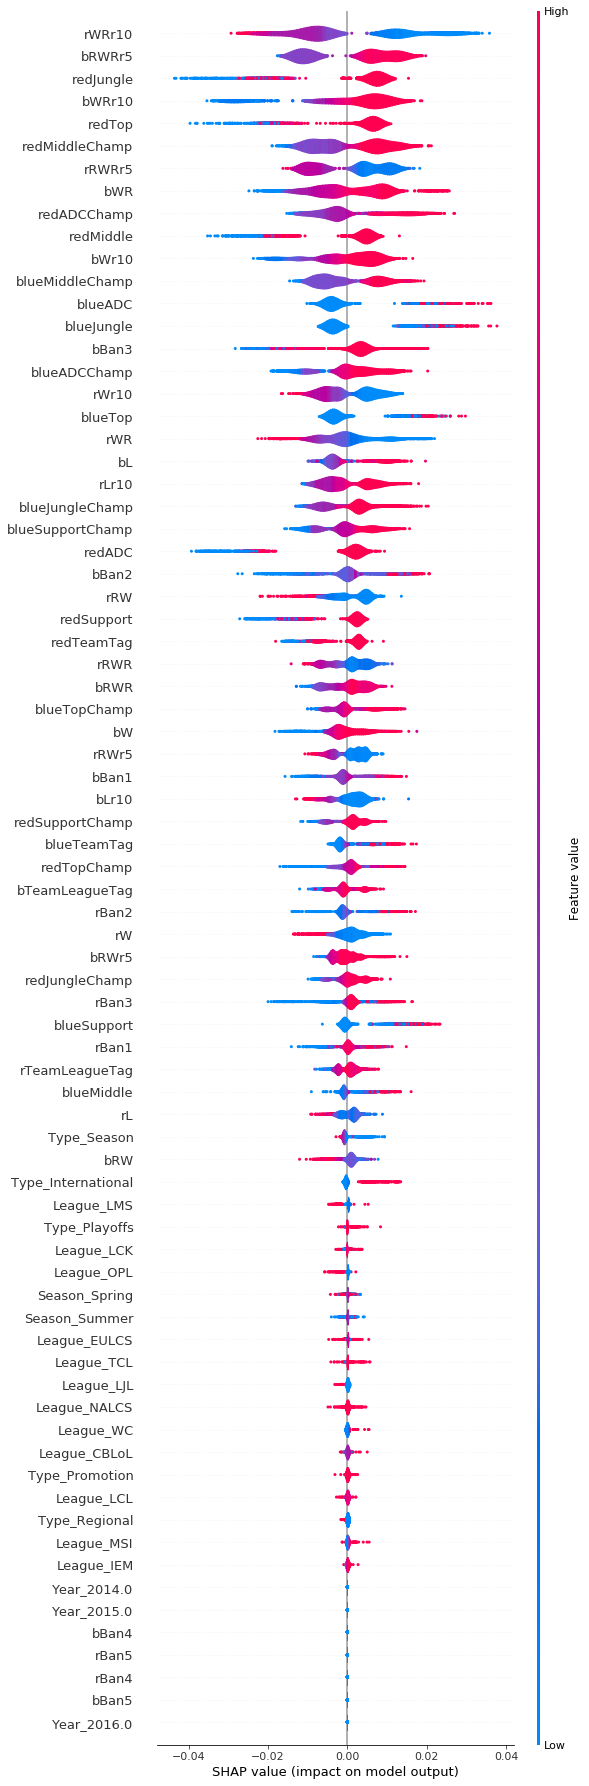

In [36]:
shap.initjs()
shap.summary_plot(shap_values[...,1], max_display=76, plot_type="violin")

위의 summary plot을 보면 레드팀 최근 전적 10판 승률이 높으면 레드팀 승리 확률을 높여주고 낮으면 블루팀 승률을 높여주는 것을 확인할 수 있다.

이와 같이 특성들을 해석하면 모델이 왜 이렇게 예측했는지 이유를 확인할 수 있다.

bar 형태로 특성 중요도를 알아보자.

bar형태로 summary plot을 출력하면 실제 예측확률에 얼마나 영향을 끼쳤는지 알 수 있다.

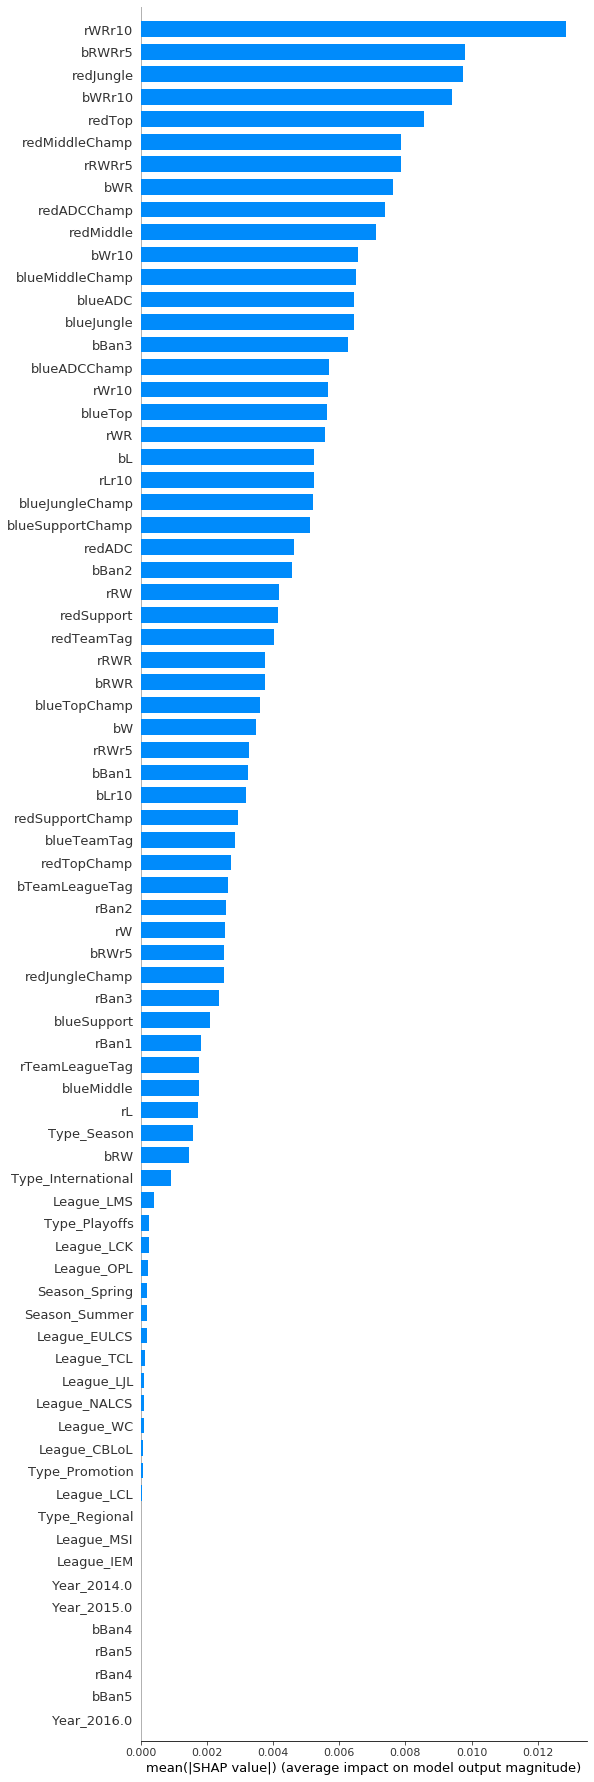

In [33]:
shap.initjs()
shap.summary_plot(shap_values[...,1],plot_type='bar', max_display= 76)

위에서 부터 예측값에 영향을 많이 끼치는 특성들을 알 수 있다.

위에서 분석한 대로 리그 이름이나 시즌, 연도, 밴4,5 등등은 예측 확률에 사실상 영향이 없다는 것을 확인할 수 있다.

Q1) 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?

승률 데이터, 선수, 선수가 고른 챔피언 등을 고려했다.

Q2) 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 

* 해당 경기가 있던 날 게임의 패치 버전이 있었다면 챔피언의 스탯을 정량적으로 표현이 가능했을 것이다.
* 해당 경기가 있던 날 선수의 스탯이 있었으면 더욱 정밀한 예측이 가능했을 것이다.

Q3) 해당 특성은 어떻게 구할 수 있을까요?

경기 기록을 정리한 사이트에서 구할 수 있다.

In [ ]:
# import pickle
# 혹시라도 런타임 초기화 되면! 샤프 밸류 불러오기. 2시간 넘게 걸려서 저장함.
# path = "/content/drive/MyDrive/Colab Notebooks/코드스테이츠/N2xx Section2/Project/shapvalues.sav"
# load_shap_values = pickle.load(open(path, 'rb'))
# print(load_shap_values)

# filename = 'shapvalues.sav'
# pickle.dump(shap_values, open(filename, 'wb'))

## 끝으로
내가 만든 분류 모델이 베이스라인 55% 보다 8% 높은 63%의 정확도를 보이는 것을 확인했다.

또한 특성공학을 통해 얻은 데이터가 예측 확률에 유의미한 변화를 주는 것을 확인했다.

하지만 선수가 누구인지. 해당 기간에 실력이 어느정도 였는지에 대한 정량적 데이터와, 해당 매치의 게임 버전이 몇 인지가 굉장히 중요한 특성이 될 것으로 예상을 하는데 이런 데이터를 구할 수 없어서 target encoder로 대략적인 정보만 뽑아냈기에 굉장히 아쉬웠다.